In [1]:
import os
os.chdir('/scratch/bva212/dl_project/code/')
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

import pickle
import time
import copy

In [2]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file

image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [3]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [4]:
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]

In [5]:
transform = torchvision.transforms.ToTensor()
datasets = {phase: LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=indices,#labeled_scene_index,
                                  transform=transform,
                                  extra_info=False
                                 ) for phase, indices in zip (['train', 'val', 'test'],
                                                      [train_idx, val_idx, test_idx]
                                                     )}

In [6]:
dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase], 
                                                  batch_size=4, 
                                                  shuffle=True, 
#                                                   num_workers=2, 
                                                  collate_fn=collate_fn
                                                 ) for phase in ['train', 'val', 'test']}

In [7]:
sample, target, road_image = iter(dataloaders['train']).next()
print(torch.stack(sample).shape)

torch.Size([4, 6, 3, 256, 306])


In [8]:
class ConcatFeatures(nn.Module):
    def forward(self, feature_maps):
#         return torch.cat(feature_maps, dim = 2)
        first_row = torch.cat(feature_maps[:3], dim=3)
        second_row = torch.cat(feature_maps[3:], dim=3)
        result = torch.cat([first_row, second_row], dim=2)
        return result

In [9]:
"""
Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
"""
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers, stride = 2, out_activation = 'relu'):
        super(DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=stride),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        feature_extractor = torchvision.models.resnet50(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
        self.feature_extractor.load_state_dict(torch.load('/scratch/bva212/dl_project/jigsaw_best_model_fe.pth'))
        
        self.concat_features = ConcatFeatures()
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        self.decoder_block = nn.Sequential(*[DecoderBlock(2048, 1024, 4, (3,2)), 
                                        DecoderBlock(1024, 512, 4),
                                        DecoderBlock(512, 128, 2),
                                        DecoderBlock(128, 32, 2),
                                        DecoderBlock(32, 1, 2, 2, 'Sigmoid'),
                                        torch.nn.Upsample((800, 800)),
                                       ])
#         model = nn.Sequential(*[feature_extractor,
#                                 concat_features,
#                                 decoder_block
#                                ])
        
    def forward(self, inputs):
        N, V, C, H, W = inputs.shape
        
        out = []
        for i in range(V):
            out.append(self.feature_extractor(inputs[:, i, :]))
        
        out = self.concat_features(out)
        out = self.decoder_block(out)
        return out

In [11]:
def get_model():
    feature_extractor = torchvision.models.resnet18(pretrained=False)
    feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
    concat_features = ConcatFeatures()
    for param in feature_extractor.parameters():
        param.requires_grad = True
    decoder_block = nn.Sequential(*[DecoderBlock(512, 256, 4), 
                                    DecoderBlock(256, 128, 4),
                                    DecoderBlock(128, 64, 2),
                                    DecoderBlock(64, 1, 2, 'Sigmoid'),
                                    torch.nn.Upsample((800, 800)),
                                   ])
    model = nn.Sequential(*[feature_extractor,
                            concat_features,
                            decoder_block
                           ])
    return model.cuda()

In [12]:
def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()
    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [13]:
def dice_loss(true, preds, epsilon = 1e-4):
    N, sh1, sh2 = preds.size()
    true = true.view(N, -1)
    preds = preds.view(N, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

In [14]:
def compute_dice(true, preds, epsilon = 1e-7):
    N, sh1, sh2 = preds.size()
    true = true.view(N, -1)
    preds = preds.view(N, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

In [15]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def train_model(model, dataloader, criterion, eval_fn, optimizer, scheduler,
                num_epochs = 10,verbose = True, print_every = 1):

    start_time = time.time()

    best_model_wts = best_model_wts = copy.deepcopy(model.state_dict())
    best_ts = 0.0

    ts_dict = {'train':[],'validation':[]}
    loss_dict = {'train':[],'validation':[]}

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        if verbose:
            if epoch % print_every == 0:
                print(f'Epoch {epoch+1}/{num_epochs}')
                print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_ts = 0.0
            running_total = 0

            for iter_, data in enumerate(dataloader[phase]):

                inputs = torch.stack(data[0])
                labels = torch.stack(data[2])

                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.LongTensor).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(labels.cpu(), outputs.cpu().squeeze())

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    threat_score = eval_fn(labels.cpu(), outputs.cpu().squeeze())

                running_ts += threat_score * inputs.size()[0]
                running_loss += loss.item() * inputs.size()[0]
                running_total += inputs.size()[0]

                print(f'Iteration: {iter_+1}/{len(dataloader[phase])} loss: {running_loss/running_total:.4f} threat_score: {running_ts/running_total:.4f}', end="\r")
                
                if iter_ % 350 == 0:
                    if os.path.exists('/scratch/bva212/dl_project/roadmap_checkpoint_model.pth'):
                        os.remove('/scratch/bva212/dl_project/roadmap_checkpoint_model.pth')
                    torch.save(best_model_wts, '/scratch/bva212/dl_project/roadmap_checkpoint_model.pth')
                    print(f'Successfully saved checkpoint model after {epoch+1} epochs and {iter_+1} iterations')

            epoch_loss = running_loss / running_total
            epoch_ts = running_ts / running_total

            if verbose:
                if epoch % print_every == 0:
                    print()
                    print(f'{phase} Loss: {epoch_loss:.4f} Threat Score: {epoch_ts:.4f}')
                    if phase == 'val':
                        plt.imshow(road_image[0])
                        plt.show()
                        inp = datasets['train'][0][0].cuda()
                        out = model(inp.unsqueeze(0))
                        plt.imshow((out>=0.5).squeeze().cpu().detach().numpy())
                        plt.show()

            if phase == 'train':
                loss_dict['train'].append(epoch_loss)
                ts_dict['train'].append(epoch_ts)
            else:
                loss_dict['validation'].append(epoch_loss)
                ts_dict['validation'].append(epoch_ts)
                if scheduler:
                    scheduler.step(epoch_loss)

            if phase == 'val' and epoch_ts > best_ts:
                best_ts = epoch_ts
                best_model_wts = copy.deepcopy(model.state_dict())
                
                if os.path.exists('/scratch/bva212/dl_project/roadmap_best_model.pth'):
                    os.remove('/scratch/bva212/dl_project/roadmap_best_model.pth')
                torch.save(best_model_wts, '/scratch/bva212/dl_project/roadmap_best_model.pth')
                print(f'Successfully updated best model after {epoch+1} epochs')
                
        if epoch % print_every == 0:
            print('')

    time_elapsed = time.time() - start_time
    print(f'Training time: {int(time_elapsed / 60)}minutes {time_elapsed % 60}s')
    print(f'Best val Threat Score: {best_ts:4f}')

    for i, phase in enumerate(['train']):

        fig = plt.figure()#figsize = (15, 12))
        plt.plot(loss_dict[phase])
        plt.title('Loss per epoch for ' + phase)
        plt.legend()
        plt.show()


        fig = plt.figure()
        plt.plot(ts_dict[phase])
        plt.title('Threat Score Score per epoch for ' + phase)
        plt.legend()
        plt.show()

    # model.load_state_dict(best_model_wts)

    return model, best_model_wts

In [16]:
model = Model().cuda()

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, )
# criterion = torch.nn.MSELoss()

Epoch 1/15
----------
Successfully saved checkpoint model after 1 epochs and 1 iterations
Successfully saved checkpoint model after 1 epochs and 351 iterations
Iteration: 693/693 loss: 0.3416 threat_score: 0.4938
train Loss: 0.3416 Threat Score: 0.4938
Successfully saved checkpoint model after 1 epochs and 1 iterations
Iteration: 126/126 loss: 0.4676 threat_score: 0.3628
val Loss: 0.4676 Threat Score: 0.3628


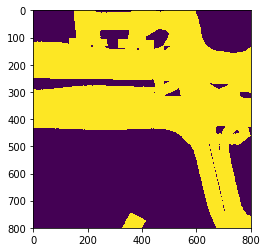

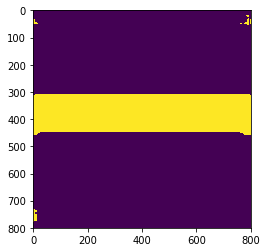

Successfully updated best model after 1 epochs

Epoch 2/15
----------
Successfully saved checkpoint model after 2 epochs and 1 iterations
Successfully saved checkpoint model after 2 epochs and 351 iterations
Iteration: 693/693 loss: 0.2758 threat_score: 0.5692
train Loss: 0.2758 Threat Score: 0.5692
Successfully saved checkpoint model after 2 epochs and 1 iterations
Iteration: 126/126 loss: 0.4355 threat_score: 0.3936
val Loss: 0.4355 Threat Score: 0.3936


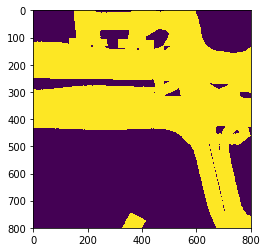

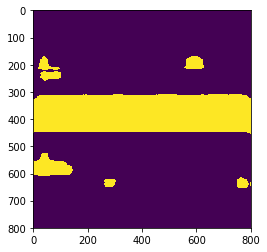

Successfully updated best model after 2 epochs

Epoch 3/15
----------
Successfully saved checkpoint model after 3 epochs and 1 iterations
Successfully saved checkpoint model after 3 epochs and 351 iterations
Iteration: 693/693 loss: 0.2425 threat_score: 0.6116
train Loss: 0.2425 Threat Score: 0.6116
Successfully saved checkpoint model after 3 epochs and 1 iterations
Iteration: 126/126 loss: 0.3529 threat_score: 0.4791
val Loss: 0.3529 Threat Score: 0.4791


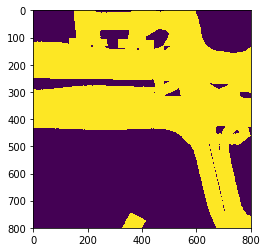

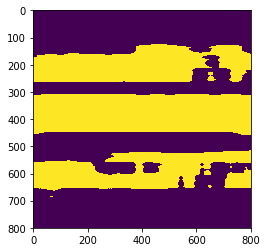

Successfully updated best model after 3 epochs

Epoch 4/15
----------
Successfully saved checkpoint model after 4 epochs and 1 iterations
Successfully saved checkpoint model after 4 epochs and 351 iterations
Iteration: 693/693 loss: 0.2227 threat_score: 0.6380
train Loss: 0.2227 Threat Score: 0.6380
Successfully saved checkpoint model after 4 epochs and 1 iterations
Iteration: 126/126 loss: 0.4198 threat_score: 0.4089
val Loss: 0.4198 Threat Score: 0.4089


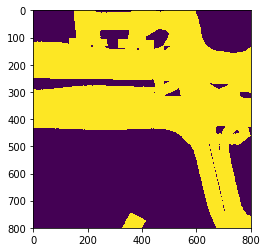

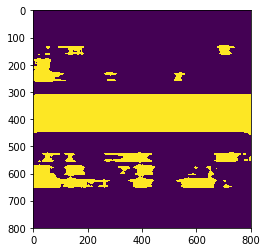


Epoch 5/15
----------
Successfully saved checkpoint model after 5 epochs and 1 iterations
Successfully saved checkpoint model after 5 epochs and 351 iterations
Iteration: 693/693 loss: 0.2100 threat_score: 0.6557
train Loss: 0.2100 Threat Score: 0.6557
Successfully saved checkpoint model after 5 epochs and 1 iterations
Iteration: 126/126 loss: 0.3203 threat_score: 0.5162
val Loss: 0.3203 Threat Score: 0.5162


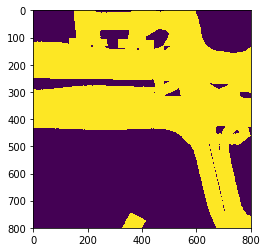

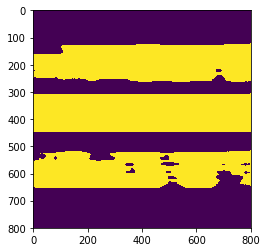

Successfully updated best model after 5 epochs

Epoch 6/15
----------
Successfully saved checkpoint model after 6 epochs and 1 iterations
Successfully saved checkpoint model after 6 epochs and 351 iterations
Iteration: 693/693 loss: 0.2015 threat_score: 0.6674
train Loss: 0.2015 Threat Score: 0.6674
Successfully saved checkpoint model after 6 epochs and 1 iterations
Iteration: 126/126 loss: 0.3329 threat_score: 0.5021
val Loss: 0.3329 Threat Score: 0.5021


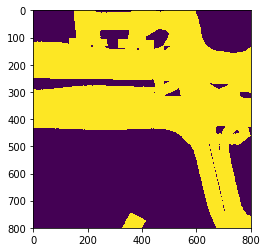

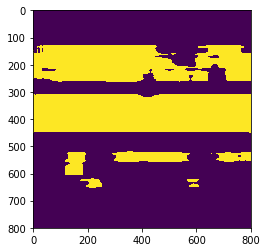


Epoch 7/15
----------
Successfully saved checkpoint model after 7 epochs and 1 iterations
Successfully saved checkpoint model after 7 epochs and 351 iterations
Iteration: 693/693 loss: 0.1957 threat_score: 0.6756
train Loss: 0.1957 Threat Score: 0.6756
Successfully saved checkpoint model after 7 epochs and 1 iterations
Iteration: 126/126 loss: 0.3430 threat_score: 0.4902
val Loss: 0.3430 Threat Score: 0.4902


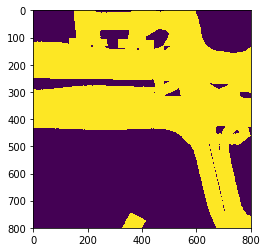

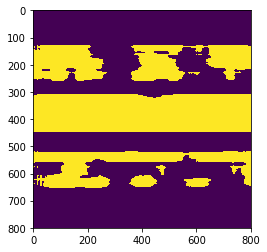


Epoch 8/15
----------
Successfully saved checkpoint model after 8 epochs and 1 iterations
Successfully saved checkpoint model after 8 epochs and 351 iterations
Iteration: 693/693 loss: 0.1918 threat_score: 0.6811
train Loss: 0.1918 Threat Score: 0.6811
Successfully saved checkpoint model after 8 epochs and 1 iterations
Iteration: 126/126 loss: 0.4107 threat_score: 0.4192
val Loss: 0.4107 Threat Score: 0.4192


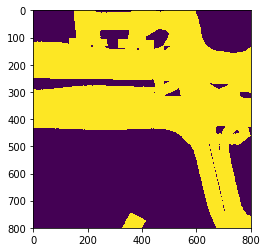

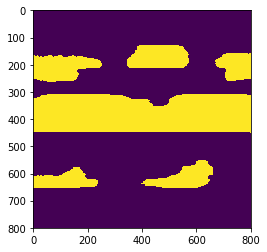


Epoch 9/15
----------
Successfully saved checkpoint model after 9 epochs and 1 iterations
Successfully saved checkpoint model after 9 epochs and 351 iterations
Iteration: 693/693 loss: 0.1887 threat_score: 0.6856
train Loss: 0.1887 Threat Score: 0.6856
Successfully saved checkpoint model after 9 epochs and 1 iterations
Iteration: 126/126 loss: 0.4202 threat_score: 0.4088
val Loss: 0.4202 Threat Score: 0.4088


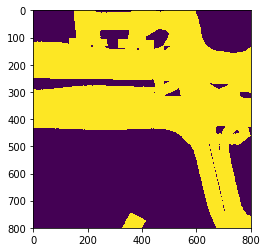

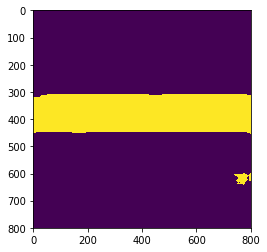


Epoch 10/15
----------
Successfully saved checkpoint model after 10 epochs and 1 iterations
Successfully saved checkpoint model after 10 epochs and 351 iterations
Iteration: 693/693 loss: 0.1875 threat_score: 0.6874
train Loss: 0.1875 Threat Score: 0.6874
Successfully saved checkpoint model after 10 epochs and 1 iterations
Iteration: 126/126 loss: 0.4159 threat_score: 0.4132
val Loss: 0.4159 Threat Score: 0.4132


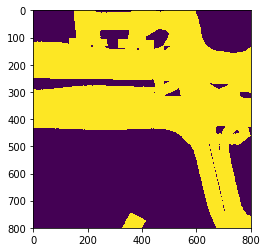

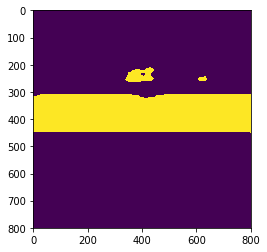


Epoch 11/15
----------
Successfully saved checkpoint model after 11 epochs and 1 iterations
Successfully saved checkpoint model after 11 epochs and 351 iterations
Iteration: 693/693 loss: 0.1840 threat_score: 0.6927
train Loss: 0.1840 Threat Score: 0.6927
Successfully saved checkpoint model after 11 epochs and 1 iterations
Iteration: 126/126 loss: 0.3651 threat_score: 0.4658
val Loss: 0.3651 Threat Score: 0.4658


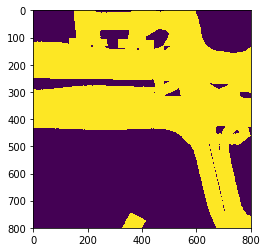

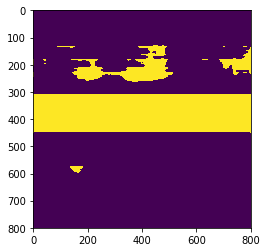


Epoch 12/15
----------
Successfully saved checkpoint model after 12 epochs and 1 iterations
Successfully saved checkpoint model after 12 epochs and 351 iterations
Iteration: 126/126 loss: 0.3019 threat_score: 0.5377
val Loss: 0.3019 Threat Score: 0.5377


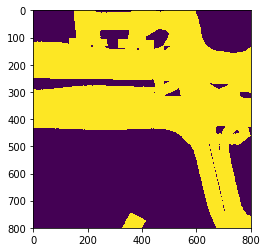

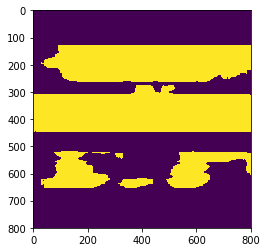

Successfully updated best model after 12 epochs

Epoch 13/15
----------
Successfully saved checkpoint model after 13 epochs and 1 iterations
Successfully saved checkpoint model after 13 epochs and 351 iterations
Iteration: 693/693 loss: 0.1801 threat_score: 0.6984
train Loss: 0.1801 Threat Score: 0.6984
Successfully saved checkpoint model after 13 epochs and 1 iterations
Iteration: 126/126 loss: 0.3099 threat_score: 0.5282
val Loss: 0.3099 Threat Score: 0.5282


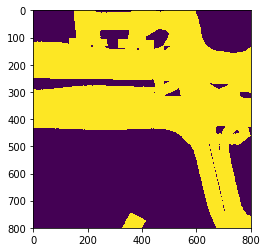

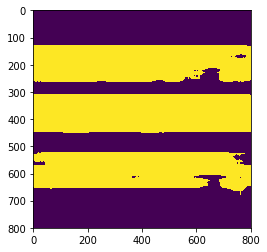


Epoch 14/15
----------
Successfully saved checkpoint model after 14 epochs and 1 iterations
Successfully saved checkpoint model after 14 epochs and 351 iterations
Iteration: 693/693 loss: 0.1791 threat_score: 0.6997
train Loss: 0.1791 Threat Score: 0.6997
Successfully saved checkpoint model after 14 epochs and 1 iterations
Iteration: 126/126 loss: 0.3182 threat_score: 0.5188
val Loss: 0.3182 Threat Score: 0.5188


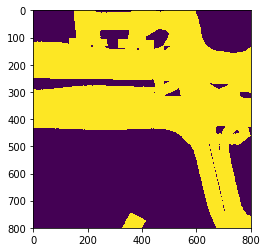

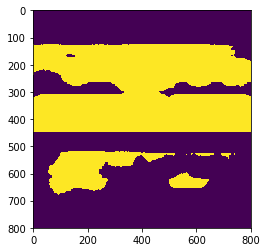


Epoch 15/15
----------
Successfully saved checkpoint model after 15 epochs and 1 iterations
Successfully saved checkpoint model after 15 epochs and 351 iterations
Iteration: 693/693 loss: 0.1767 threat_score: 0.7029
train Loss: 0.1767 Threat Score: 0.7029
Successfully saved checkpoint model after 15 epochs and 1 iterations
Iteration: 126/126 loss: 0.3314 threat_score: 0.5035
val Loss: 0.3314 Threat Score: 0.5035


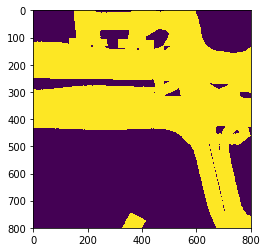

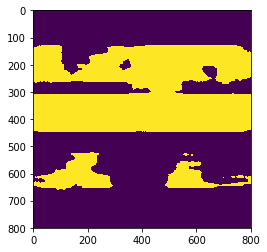

No handles with labels found to put in legend.



Training time: 277minutes 35.32040476799011s
Best val Threat Score: 0.537671


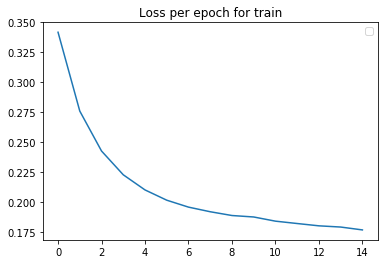

No handles with labels found to put in legend.


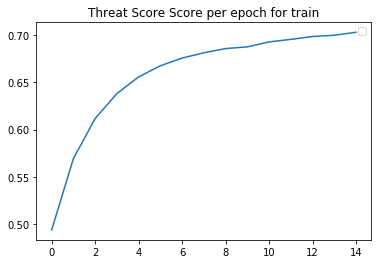

In [18]:
model, best_model_wts = train_model(model, dataloaders, dice_loss, compute_ts_road_map, 
                                    optimizer, None, 15)

### Sample Predictions

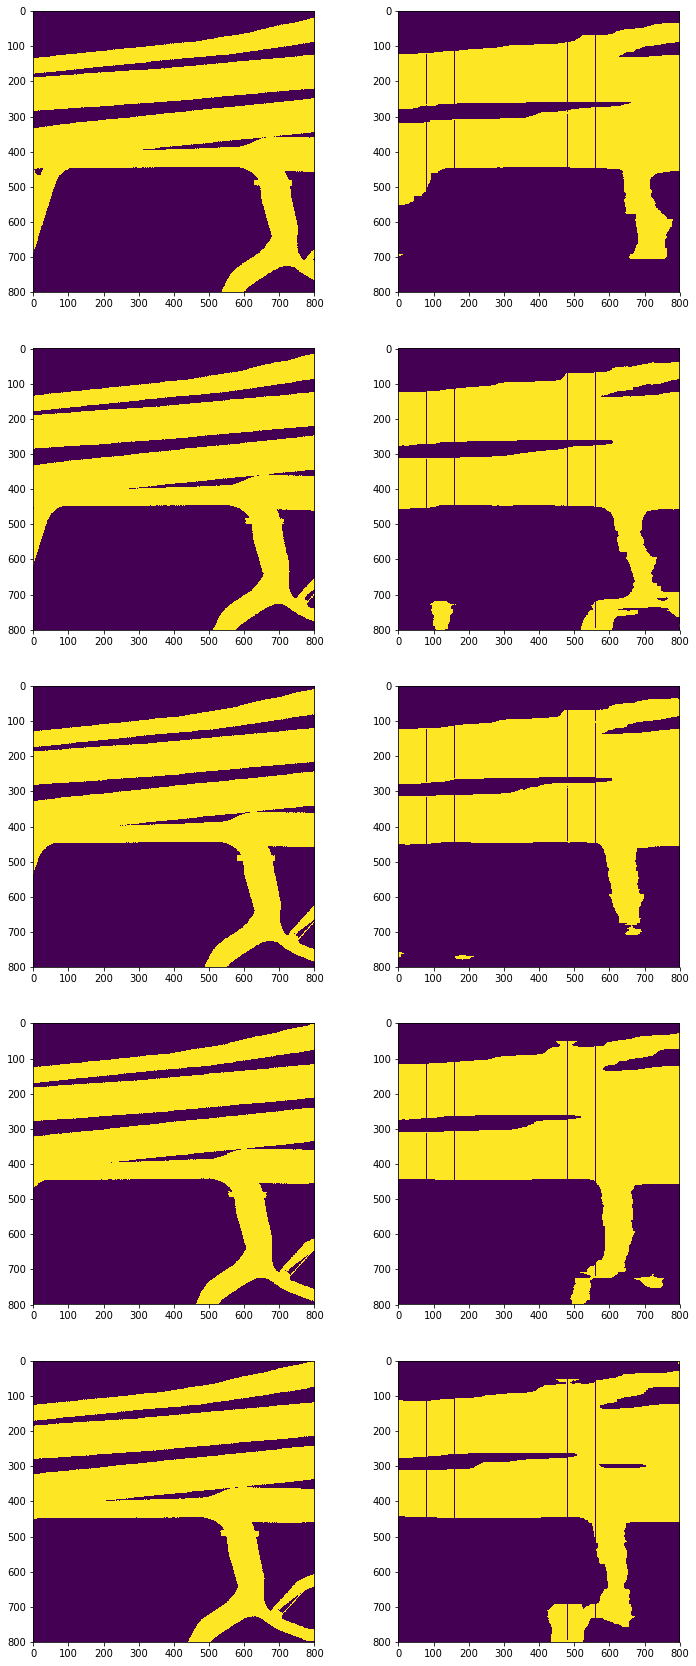

In [581]:
n_samples = 5
start = 1000
threshold = 0.5

fig, ax = plt.subplots(n_samples, 2, figsize = (12, 30))

for i in range(start, start + n_samples):
    ax[i-start, 0].imshow(labeled_trainset[i][2].cpu().numpy())
    
    inp = labeled_trainset[i][0].cuda()
    out = model(inp)
    ax[i-start, 1].imshow((out>threshold).squeeze().cpu().detach().numpy())

In [594]:
torch.save(best_model_wts, '/scratch/bva212/dl_project/binary_road_map_resnet18.pth')

In [38]:
path = '/scratch/bva212/dl_project/roadmap_best_model.pth'
load = torch.load(path)

In [39]:
model.load_state_dict(load)

<All keys matched successfully>

In [40]:
def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()
    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [41]:
model.eval()
for phase in ['train', 'val', 'test']:

    total = 0
    total_ts_road_map = 0
    verbose = True
    
    for i, data in enumerate(dataloaders[phase]):
        total += 1
        sample, target, road_image = data
        sample = torch.stack(sample).cuda()

        with torch.no_grad():
            predicted_road_map = model(sample).cpu()

        ts_road_map = compute_ts_road_map(predicted_road_map.squeeze(1), torch.stack(road_image))

        total_ts_road_map += ts_road_map

        if verbose and i % 100 == 0:
            print(f'{i} - Road Map Score: {ts_road_map:.4}', end="\r")

    print(f'\n{phase} Threat Score: {total_ts_road_map / total:.4}')

600 - Road Map Score: 0.6342
train Threat Score: 0.5708
100 - Road Map Score: 0.4658
val Threat Score: 0.5385
0 - Road Map Score: 0.5034
test Threat Score: 0.4578
